<a href="https://colab.research.google.com/github/delhian/cv_course/blob/main/Home%20Tasks/flower_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
from typing import Tuple
import numpy as np
from torch.utils.data import Dataset, Subset
import torch
from torchvision.datasets import ImageFolder, DatasetFolder
from torchvision import transforms
from torchvision.transforms import Compose, ToTensor, Resize
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import pandas as pd
import torch.nn as nn

from torchvision import models
from tqdm.notebook import tqdm


from sklearn.metrics import f1_score
from torch.optim.lr_scheduler import ExponentialLR

In [2]:
torch.cuda.is_available()

True

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
path = '/content/drive/MyDrive/flowerdata-module5.zip'
!unzip -qqo {path} -d ./

In [14]:
train_transforms = transforms.Compose([\
                                              transforms.RandomRotation(45),
                                              transforms.RandomResizedCrop(299),
                                              transforms.RandomHorizontalFlip(),
                                              transforms.RandomVerticalFlip(),
                                              transforms.ToTensor(),
                                              transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225]),
                                       ])

val_transforms = transforms.Compose([
                                              transforms.Resize((299, 299)),
                                              transforms.ToTensor(),
                                              transforms.Normalize([0.485, 0.456, 0.406],
                                                                 [0.229, 0.224, 0.225])
                                     ])

In [15]:
train_dataset = ImageFolder('/content/train/train/', transform=train_transforms)

val_dataset = ImageFolder('/content/train/train/', transform=val_transforms)

Делим: train vs validation:

In [16]:
filelist = pd.DataFrame([(x[0].split('/')[-1] , x[1]) for x in train_dataset.imgs], columns = ['filename', 'label'])
print(filelist.head())

train_idx, val_idx = train_test_split(filelist['filename'], test_size=0.25, stratify= filelist.label)

train_dataset = Subset(train_dataset, train_idx.index)
val_dataset = Subset(val_dataset, val_idx.index)
print(len(train_dataset), len(val_dataset))

          filename  label
0  image_06734.jpg      0
1  image_06735.jpg      0
2  image_06736.jpg      0
3  image_06737.jpg      0
4  image_06738.jpg      0
4914 1638


Определяем train_DataLoader, val_DataLoader

In [17]:
batch_size = 32

train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size, shuffle=True, num_workers=2)

train_dataloader:


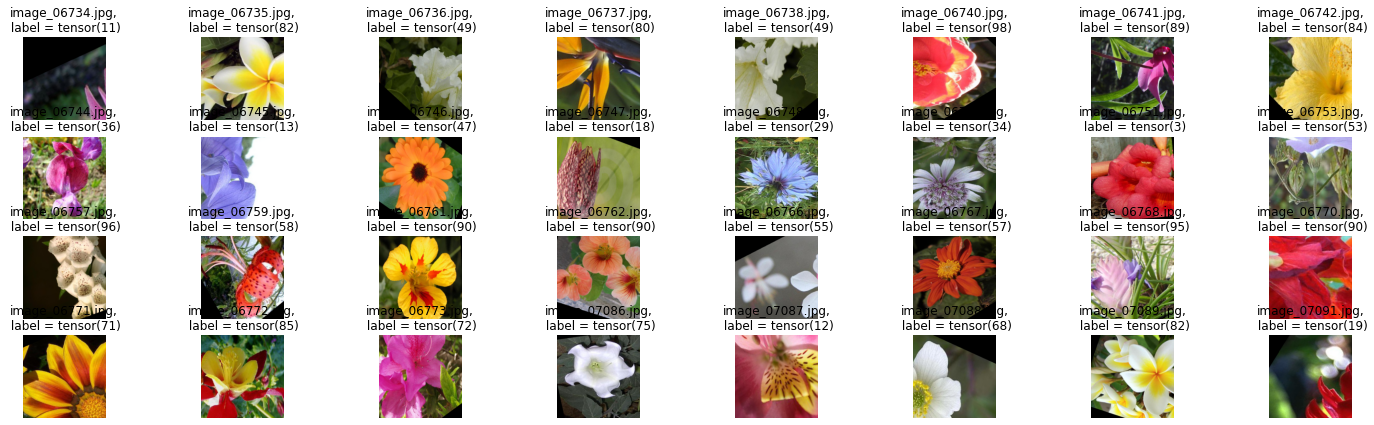

val_dataloader:


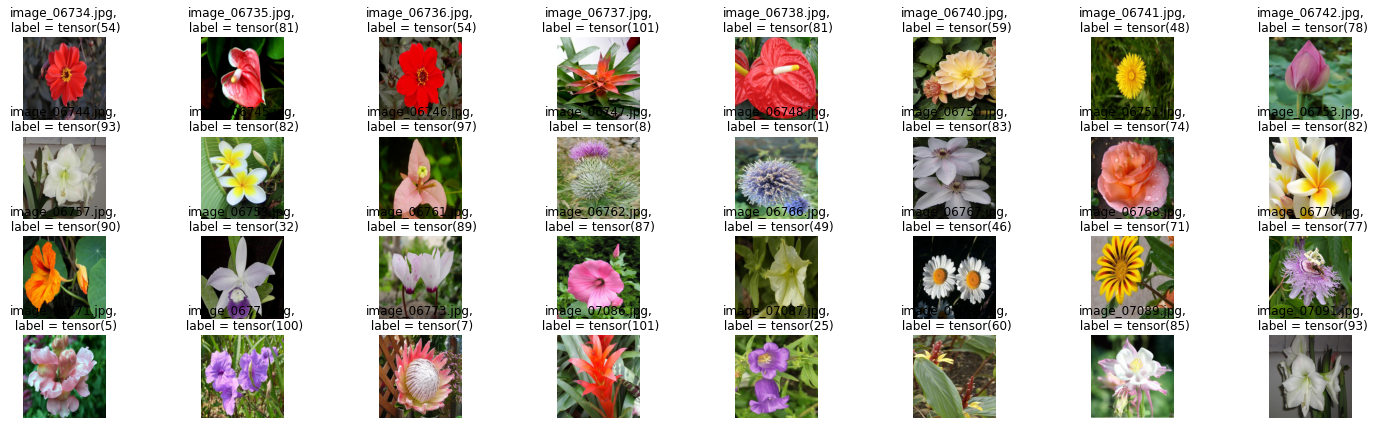

In [13]:
def plot_examples(inputs, classes):
  figure = plt.figure(figsize=(25, 7))
  cols, rows = 8, 4
  for i in range(0, cols * rows):
    img, label = inputs[i], classes[i]
    figure.add_subplot(rows, cols, i+1)
    img = img.numpy()
    img = img.swapaxes(0,1)
    img = img.swapaxes(1,2)
    filename = filelist['filename'][i]
    plt.title(f'{filename},\n label = {str(label)}')
    plt.axis("off")
    plt.imshow(img)
  plt.show()

print('train_dataloader:')
inputs, classes = next(iter(train_dataloader))
plot_examples(inputs, classes)
print('val_dataloader:')
inputs, classes = next(iter(val_dataloader))
plot_examples(inputs, classes)

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [19]:
# net = models.efficientnet_b1(pretrained=True)
net = models.resnet34(pretrained=True)
net.classifier = torch.nn.Linear(in_features=512, out_features=102, bias=True)

for parameter in net.parameters():
    parameter.requres_grad = True

for module in [net.conv1, net.bn1, net.layer1, net.layer2]:
    for parameter in module.parameters():
        parameter.requres_grad = False

net= net.to(device)

In [20]:
checkpoint_path = '/content/drive/MyDrive/checkpoint.pth'

def save_checkpoint(model, optimizer, checkpoint_path, epoch):

    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch': epoch
    }, checkpoint_path)

def load_checkpoint(model, checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    return model, optimizer, epoch

In [31]:
def train_model(net,
                optimizer,
                criterion,
                train_dataloader,
                val_dataloader,
                num_epochs):
  
    # check checkpoint
    try:
      net, optimizer, start_epoch = load_checkpoint(net, checkpoint_path)
    except:
      start_epoch = 0
  
    loss_train, loss_valid = [], []
    f1_train, f1_valid = [], []

    scheduler = ExponentialLR(optimizer, gamma=0.99)

    for epoch in range(start_epoch + 1, num_epochs):
        print(f'epoch: {epoch} of {num_epochs}')
        print(f'LR: {scheduler.get_last_lr()[0]}')
        torch.set_grad_enabled(True)
        net.train()
        losses, f1 = [], []
        print('TRAIN:', end =' ')
        for i, (images, target) in enumerate(tqdm(train_dataloader)):
            # print(i, end =', ')
            images = images.to(device)
            target = target.to(device)
            output = net(images)
            loss = criterion(output, target)
            losses.append(loss.item())
            f1.append(f1_score(target.cpu().numpy(), net(images).argmax(1).cpu().numpy(), average='macro'))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        mean_losses, mean_f1 = np.mean(losses),  np.mean(f1)
        print(f'mean_losses: {mean_losses}, mean_f1: {mean_f1}')
        loss_train.append(mean_losses)
        f1_train.append(mean_f1)
        torch.set_grad_enabled(False)
        net.eval()
        losses, f1 = [], []
        print('VALIDATION:', end =' ')
        for i, (images, target) in enumerate(tqdm(val_dataloader)):
            # print(i, end =', ')
            images = images.to(device)
            target = target.to(device)
            output = net(images)
            loss = criterion(output, target)
            losses.append(loss.item())
            f1.append(f1_score(target.cpu().numpy(), net(images).argmax(1).cpu().numpy(), average='macro'))
        mean_losses, mean_f1 = np.mean(losses),  np.mean(f1)
        print(f'mean_losses: {mean_losses}, mean_f1: {mean_f1}')

        loss_valid.append(mean_losses)
        f1_valid.append(mean_f1)
        scheduler.step()
        save_checkpoint(net, optimizer, checkpoint_path, epoch)

    return loss_train, f1_train, loss_valid, f1_valid

In [28]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)

In [ ]:
loss_train, f1_train, loss_valid, f1_valid = train_model(net = net,
                                                             optimizer = optimizer,
                                                             criterion = criterion,
                                                             train_dataloader = train_dataloader,
                                                             val_dataloader = val_dataloader,
                                                             num_epochs = 200)

epoch: 3 of 200
LR: 0.009801
TRAIN: 

  0%|          | 0/154 [00:00<?, ?it/s]

In [1]:
plt.figure(figsize=(14, 6))

plt.subplot(121)
plt.plot(range(1, len(loss_train) + 1), loss_train, color="b")
plt.plot(range(1, len(loss_train) + 1), loss_valid, color="r")
plt.xlabel("epochs")
plt.title("loss")

plt.subplot(122)
plt.plot(range(1, len(loss_train) + 1), f1_train, color="b")
plt.plot(range(1, len(loss_train) + 1), f1_valid, color="r")
plt.xlabel("epochs")
plt.title("mean_f1")

plt.show()

NameError: ignored

Теперь для того, чтобы загрузить модель нам необходимо создать класс модели и вызвать метод load(). 

In [ ]:
from PIL import Image

class TestDataset(Dataset):
    def __init__(self, path, transform=None):
        self.path = path
        self.files = []
        for (dirpath, _, filenames) in os.walk(self.path):
            for f in filenames:
                if f.endswith('.jpg'):
                    p = {}
                    p['img_path'] = dirpath + '/' + f
                    self.files.append(p)
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def pil_loader(self, path):
        with open(path, 'rb') as f:
            img = Image.open(f)
            return img.convert('RGB')

    def __getitem__(self, idx):
        img_path = self.files[idx]['img_path']
        file_name = img_path.split('/')[-1]
        image = self.pil_loader(img_path)
        if self.transform:
            image = self.transform(image)
        return image, file_name

In [ ]:
test_transforms = transforms.Compose([
                                              transforms.Resize((224, 224)),
                                              transforms.ToTensor(),
                                              transforms.Normalize([0.485, 0.456, 0.406],
                                                                 [0.229, 0.224, 0.225])
                                     ])

test_transforms_without_Normalize  = transforms.Compose([
                                              transforms.Resize((224, 224)),
                                              transforms.ToTensor(),
                                              # transforms.Normalize([0.485, 0.456, 0.406],
                                              #                    [0.229, 0.224, 0.225])
                                     ])


test_dataset = TestDataset('/content/test/valid', transform=test_transforms)
test_dataset_without_Normalize = TestDataset('/content/test/valid', transform=test_transforms_without_Normalize)
# testloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

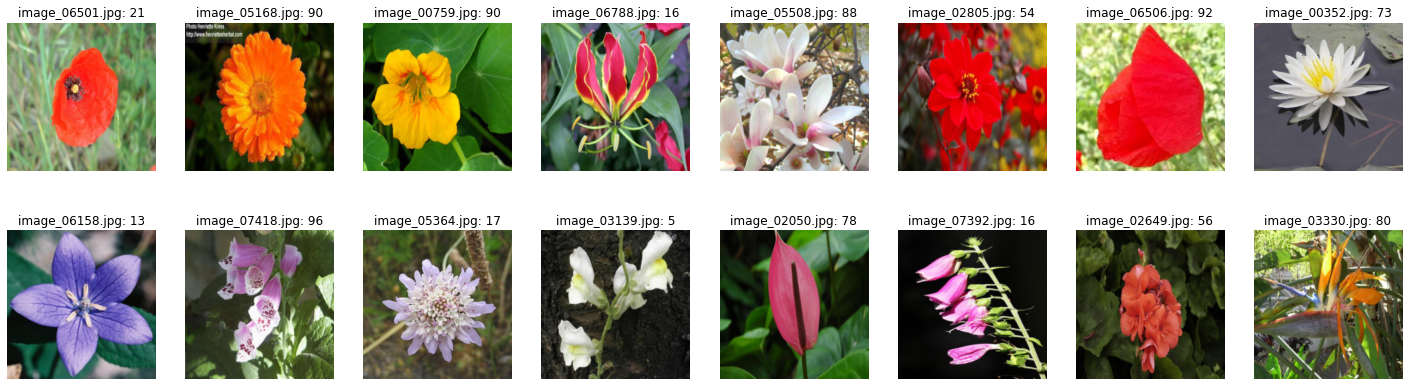

In [ ]:
figure = plt.figure(figsize=(25, 7))
cols, rows = 8, 2

for i in range(cols * rows):
    img, _ = test_dataset[i]
    img_w, filename = test_dataset_without_Normalize[i]
    img = img.to(device)
    output = net(img[None, :, :, :])
    output = output.argmax(1).cpu().numpy()
    figure.add_subplot(rows, cols, i+1)

    img_w = img_w.swapaxes(0,1)
    img_w = img_w.swapaxes(1,2)
    plt.title(f'{filename}: {output[0]}')
    plt.axis("off")
    plt.imshow(img_w)

In [ ]:
testloader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

In [ ]:
images, filename = next(iter(testloader))
images = images.to(device)
output = net(images)
output = output.argmax(1).cpu().numpy()
Id_Category_map = {x:y for (x ,y) in zip(filename, output)}

In [ ]:
submission = pd.read_csv('sample_submission.csv')

submission['Category'] = submission['Id'].map(Id_Category_map)

In [ ]:
submission.to_csv('submission.csv', index=False)
pd.read_csv('submission.csv')

,Id,Category
0,image_00028.jpg,83
1,image_00059.jpg,77
2,image_00061.jpg,77
3,image_00063.jpg,77
4,image_00071.jpg,77
...,...,...
813,image_08105.jpg,11
814,image_08113.jpg,95
815,image_08145.jpg,55
816,image_08155.jpg,85
